# Credit Card Fraud

Predicting fraud using a variation of models

In [2]:
# general dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
# sci-kit learn dependencies (for modeling)
# preprocessing and validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

# strictly model dependencies now
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Data Preprocessing & Investigation

Since we're dealing with fraud data, we can assume that the data will have some class imbalance problems. We'll look into the class imbalance problems and see what we can do to create a balanced dataset to create and test a model with.

The dataset I'll be using comes from a kaggle challenge: https://www.kaggle.com/mlg-ulb/creditcardfraud


In [4]:
# load our data
df = pd.read_csv("data/creditcard.csv")

In [5]:
# see a sneak preview
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# get the shape of our data
df.shape

(284807, 31)

From the above information we can see that we have a large amount of data, **287,807** rows and **31** features. Note: from the data source documentation the authors note that V1-28 are the result of PCA or some other dimensionality reduction technique in order to anonymitize sensitive user data.

Let's now plot the distribution of the **Class** features, which identifies the transaction as being fraudulent (1) or not (0)

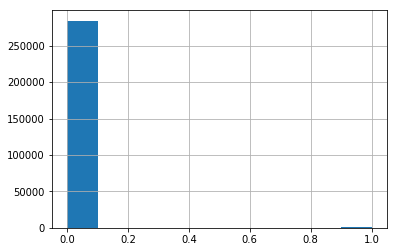

In [7]:
df.Class.hist()

In [8]:
# get percentage of whole dataset that Class = 1 (the transaction was fraudulent)
fraudulent_percentage = (len(df[df.Class == 1]) / len(df)) * 100
print("{0:0.2f}% of the dataset consists of fraudulent transactions".format(fraudulent_percentage))

0.17% of the dataset consists of fraudulent transactions


This yields a frightening result... Our possible dataset is much much smaller than at first thought. We can really only use a maximum of 0.17% of the total dataset. This class imbalance is rediculous and needs to be dealt with.

### Class "Re-Balancing"

In order to circumvent the class imbalance, two things come to mind:

1) Subsample with 50% non-fraud, 50% fraud.

Oversampling the minority class would better generalize the model to the class imbalance in the future. We could also compensate that by using an L2 regularizer like a Ridge Classifer.

We'll split the data two ways, even sample, and oversampling the minority case.

To oversample the minority class, we can use SMOTE (Synthetic Minority Over-sampling Technique).

In [9]:
# for our new dataset, resample
# for this we can use a package called imblearn
# we'll apply SMOTE (Synthetic Minority Over-sampling Technique) to oversample
# our minority class
from imblearn.over_sampling import SMOTE

In [10]:
features = df.drop(columns=["Class"])
target = df["Class"]

In [11]:
even_splitter = SMOTE(sampling_strategy="all")

In [12]:
even_split = even_splitter.fit_resample(features, target)

In [13]:
even_features = pd.DataFrame(even_split[0], columns=features.columns)
even_target = pd.DataFrame(even_split[1], columns=["Class"])

In [14]:
print(len(even_target[even_target["Class"] == 1]))
print(len(even_target[even_target["Class"] == 0]))

284315
284315


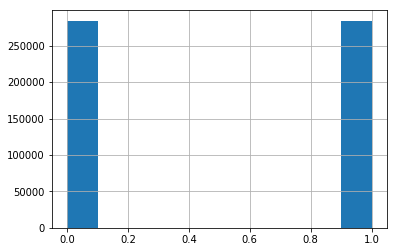

In [15]:
# plot some distributions now
even_target.Class.hist()

Now that we oversampled our minority class, let's plot the difference in correlation between the full, un-modified sample, and the sample with the over sampled minority

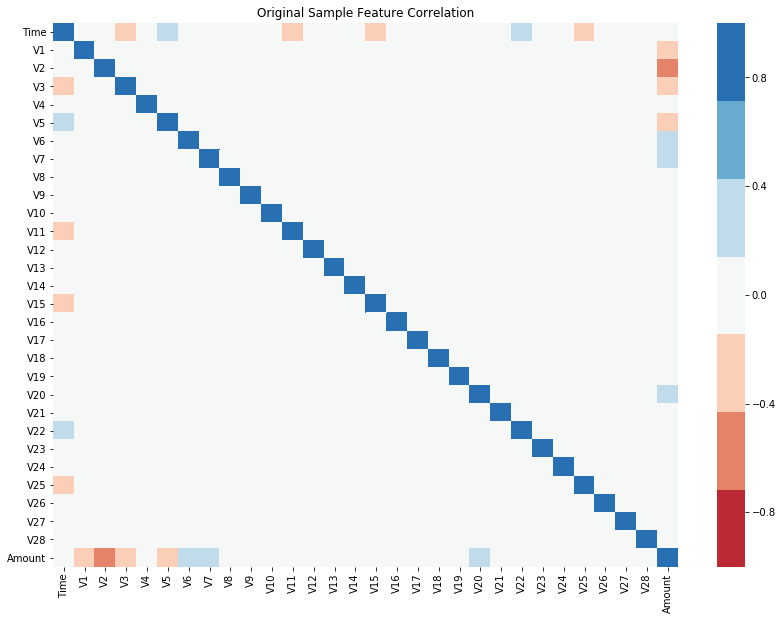

In [16]:
# original feature correlation
_, axis = plt.subplots(figsize=(14,10))
red_palette = sns.color_palette("RdBu", 7)
sns.heatmap(
    features.corr(),
    cmap=red_palette,
    ax=axis,
    vmin=-1,
    vmax=1
).set_title("Original Sample Feature Correlation")

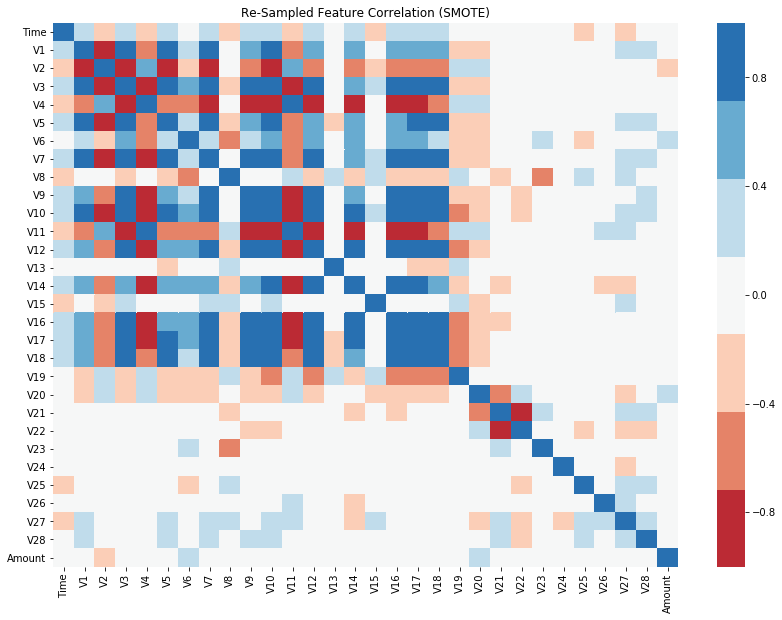

In [17]:
_, axis = plt.subplots(figsize=(14,10))
sns.heatmap(
    even_features.corr(),
    cmap=red_palette,
    ax=axis,
    vmin=-1,
    vmax=1
).set_title("Re-Sampled Feature Correlation (SMOTE)")

From the heatmaps above, we can see the increase in correletion between features, both positive and negative.

Now let's continue looking into the data

In [25]:
# modeling time

# let's create 5 models:

#1) Logistic Regression
#2) RidgeClassifier
#3) LinearSVC
#4) SVC
#5) RandomForrest

lr = LogisticRegression()
rc = RidgeClassifier()
lsvc = LinearSVC()
svc = SVC()
rf = RandomForestClassifier()

classifiers = {
    "Logisitic Regression": lr,
    "Ridge Classifier": rc,
    "Linear SVC": lsvc,
    "SVC": svc,
    "Random Forrest": rf
}

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=10)

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

In [ ]:
# train the models
classifier_roc_scores = {
    
}
for classifier_name, model in classifiers.items():
    model.fit(X_train, y_train)
    
    model_pred = cross_val_predict(model, X_train, y_train, cv=5)
    
    roc_results = roc_curve(y_train, model_pred)
        
    classifier_roc_scores[classifier_name] = roc_results

/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 

In [ ]:
# plot the curve with all of the models
roc_auc_score
def graph_roc_curve_multiple(roc_scores):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top {} Classifiers'.format(len(roc_scores)), fontsize=18)
    
    for name, model in classifier_roc_scores.items():
        false_positive_rate, true_positive_rate, 
        plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
   
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    plt.show()